# ASL Handshape Data

## Description of data
Link to data found on Nicolas Pugeault's website
(http://empslocal.ex.ac.uk/people/staff/np331/index.php?section=FingerSpellingDataset). The dataset is of 24 static handshapes corresponding to English letters (excluding the letters "J" and "Z" since they require motion). The data comprises of 5 different non-native signers of about 60,000 RGB (intensity) images and depth images. The images have some rotational variance as the subject moved their hand during the image capture.

## Notebook setup

Run this section if data is already partially processed 

In [1]:
import os
import re
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image 
from functools import reduce

## Variables needed for reference throughout sections
dataset_url = 'www.cvssp.org/FingerSpellingKinect2011/fingerspelling5.tar.bz2'
filename = 'fingerspelling5.tar.bz2'
# Data directory
final_data_dir = 'data'
# Data's top-level directory (after download & decompreshion)
dataset_dir = 'dataset5'
# Filename for image sizes
img_sizes_csv = 'image_sizes.csv' 

## Grabbing data

Below is a script to download the data to the local machine. Note that compressed file is over 2GB. If the data was already retrieved, you can skip this section and start with the preprocessing the dataset.

In [2]:
# Link to dataset and 
os.system('wget {URL}'.format(URL=dataset_url))

0

In [3]:
# Uncompress
os.system('tar xjf {}'.format(filename))

0

## Removing and relabelling data

Only RGB image data is needed and should be relabelled so that the files can be easily be placed into one directory but still contain metadata for classification, validation, and testing.

In [4]:
# Make a new data directory if doesn't exist
if not os.path.exists(final_data_dir):
    os.makedirs(final_data_dir)

# Define patterns for depth files & RGB files 
# Format: `depth_0_0528.png` & `color_12_0137.png`
pattern_depth_file = '(depth\w*.png)'
pattern_rgb_file = 'color_\d*_(\d*).png'
# Number of files renamed/delted
n_del, n_rename = 0,0

# Save that this is a new subject (numerical since letter can be confusing)
# Each subject in directory with a letter ('A','B','C',...)
for (subject_id, subject_dir) in enumerate(os.listdir(dataset_dir)):
    # Directories for each letter (excluding "j" & "z")
    path_to_subject = os.path.join(dataset_dir, subject_dir)
    
    for letter_dir in os.listdir(path_to_subject):
        # Use letter as number ('a' starts @ 00)
        letter_id = ord(letter_dir.lower()) - ord(('a'))
        letter_id = '0{}'.format(letter_id) if letter_id < 10 else letter_id
        path_to_letter = os.path.join(path_to_subject, letter_dir)
        
        for image_file in os.listdir(path_to_letter):
            # Remove depth file
            if re.search(pattern_depth_file, image_file):
                path_depth_file = os.path.join(path_to_letter, image_file)
                os.remove(path_depth_file)
                # Inform depth file removed
                print('\r#{}: Depth file deleted {}'.format(n_del,path_depth_file), end='')
                n_del += 1
            else:
                # Get ID of each file (None if not matched)
                num_id = re.match(pattern_rgb_file, image_file)
                if num_id:
                    # Get the matching parathesis only
                    num_id = num_id.group(1)
                    path_image_file = os.path.join(path_to_letter, image_file)
                    # Rename image
                    new_image_name = '{}_{}_{}.png'.format(letter_id,subject_id,num_id)
                    new_path_image_file = os.path.join(final_data_dir, new_image_name)
                    os.rename(path_image_file, new_path_image_file)
                    # Inform image renamed
                    print('\r#{}: {} renamed from {}'.format(n_rename,new_path_image_file,path_image_file), end='')
                    n_rename += 1
            sys.stdout.flush()

#65773: data/22_4_0183.png renamed from dataset5/A/w/color_22_0183.png

## Exploring image size

The next step would be to make all images the same size, however it is unclear what are the images' current sizes. So a quick exploration will done to determine how the images will be resized (and padded if needed).

In [5]:
# Create headers for dataframe columns
img_dict = {'filename':[], 'width':[], 'height':[]}

# Get only relevant files
file_list = [x for x in os.listdir(final_data_dir) if re.search('\w*png', x)]
for img_filename in file_list:
    # Open up the image file and get relevant info
    img_path = os.path.join(final_data_dir, img_filename)
    img = Image.open(img_path)
    width, height = img.size
    # Add it to a dictionary before converting to dataframe
    img_dict['filename'].append(img_filename)
    img_dict['width'].append(width)
    img_dict['height'].append(height)
    
# Convert to dataframe and save to CSV    
img_df = pd.DataFrame(data=img_dict)
img_df.to_csv(img_sizes_csv)

In [7]:
# Load in CSV to df if continuing
img_df = pd.read_csv(img_sizes_csv)

In [8]:
# Creating some new variables to get better idea of images
img_df['area'] = img_df.apply(lambda row: row.width * row.height, axis=1)
img_df['aspect'] = img_df.apply(lambda row: row.width / row.height, axis=1)

Text(0, 0.5, 'Number of images')

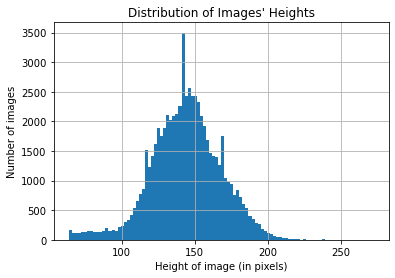

In [9]:
ax = img_df['height'].hist(bins=100)

ax.set_title('Distribution of Images\' Heights')
ax.set_xlabel('Height of image (in pixels)')
ax.set_ylabel('Number of images')

Text(0, 0.5, 'Number of images')

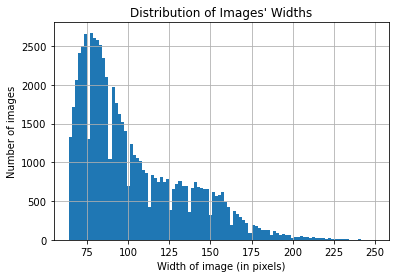

In [11]:
ax = img_df['width'].hist(bins=100)

ax.set_title('Distribution of Images\' Widths')
ax.set_xlabel('Width of image (in pixels)')
ax.set_ylabel('Number of images')

Text(0, 0.5, 'Number of images')

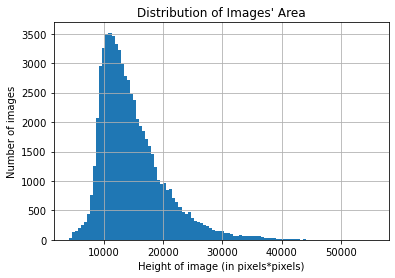

In [12]:
# Observing the total pixel area
ax = img_df['area'].hist(bins=100)

ax.set_title('Distribution of Images\' Area')
ax.set_xlabel('Height of image (in pixels*pixels)')
ax.set_ylabel('Number of images')

Text(0, 0.5, 'Number of images')

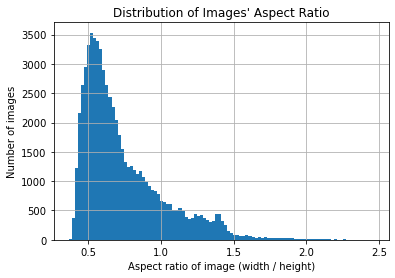

In [13]:
# Observing the pixel aspect ratio
ax = img_df['aspect'].hist(bins=100)

ax.set_title('Distribution of Images\' Aspect Ratio')
ax.set_xlabel('Aspect ratio of image (width / height)')
ax.set_ylabel('Number of images')

In [14]:
img_df.describe()

,Unnamed: 0,width,height,area,aspect
count,65774.00000,65774.00000,65774.000000,65774.000000,65774.000000
mean,32886.50000,103.16952,143.769103,14847.704260,0.741979
std,18987.46264,31.83872,23.951306,5443.550522,0.282801
min,0.00000,64.00000,64.000000,4160.000000,0.368421
25%,16443.25000,78.00000,129.000000,11005.750000,0.537313
50%,32886.50000,93.00000,144.000000,13580.000000,0.649007
75%,49329.75000,123.00000,159.000000,17375.000000,0.872549
max,65773.00000,249.00000,272.000000,55458.000000,2.460526


### Image sizes observations

Looking at our images different sizes, one can pick up on some patterns in the data. First the smallest the height or width each goes down is $64$ pixels while the maximums go to over about $270$ and $250$ pixels for height and width respectively. Height is roughly a normal curve centered near $145$ pixels while width is skewed towards smaller values with an average of about $100$ pixels.

Aspect ratio and area metrics were also created from the data. The area gives us literally how many inputs there would be for the model if we simply input the pixels. The aspect ratio gives the relative size of height and width.

One can notice that the aspect ratio trends below $1.0$ meaning that most images are taller than they are wide. This makes sense since the images likely capture part of the arm which for most signs creates a more vertical image. Less than $25\%$ of all images have an aspect ratio above the $1.0$ which corresponds with images wider than they are tall.

One can also notice that the area metric is heavily skewed toward smaller values. This fits with the aspect ratio and likely is because of the skew in width. The average number of pixels in the images is about $15000$ pixels and less than $25\%$ have more than $18000$ pixels.

### Determinig image resizing action

Taking this information from the dataset, a procedure can be created to resize these images. Since the model will be using a convolutional neural network (CNN) architecture, the images must be fixed and benefits in being square that is the width and height must be equal. Ideally, one would like the images to keep as much information as possible during the resize but due to computing resource limits, the images shouldn't simply enlarged to fit to the maximums. Therefore, in resizing the images most images should retain most (if not all) of their information while there are fewer images losing information. Note that the images should not be cropped since they have already been cropped around the images' handshapes.

From the data exploration, it can be observed that most images are taller than wide. It would then make sense that resizing the data should favor taller images since this is more common in the data. One solution is to add padding to images so that the width matches with the height. However, by adding the padding can give bias to the model if particular letters have differing aspect ratios (see the histogram plots below). In other words, the model could simply learn based on the padding instead of the handshape in the image. Thus stretching/squeezing or rescaling the image seems to be preferred even if the images will lose more information. 

array([[<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'B'}>,
        <AxesSubplot:title={'center':'C'}>,
        <AxesSubplot:title={'center':'D'}>,
        <AxesSubplot:title={'center':'E'}>],
       [<AxesSubplot:title={'center':'F'}>,
        <AxesSubplot:title={'center':'G'}>,
        <AxesSubplot:title={'center':'H'}>,
        <AxesSubplot:title={'center':'I'}>,
        <AxesSubplot:title={'center':'K'}>],
       [<AxesSubplot:title={'center':'L'}>,
        <AxesSubplot:title={'center':'M'}>,
        <AxesSubplot:title={'center':'N'}>,
        <AxesSubplot:title={'center':'O'}>,
        <AxesSubplot:title={'center':'P'}>],
       [<AxesSubplot:title={'center':'Q'}>,
        <AxesSubplot:title={'center':'R'}>,
        <AxesSubplot:title={'center':'S'}>,
        <AxesSubplot:title={'center':'T'}>,
        <AxesSubplot:title={'center':'U'}>],
       [<AxesSubplot:title={'center':'V'}>,
        <AxesSubplot:title={'center':'W'}>,
        <AxesSubplot:title={

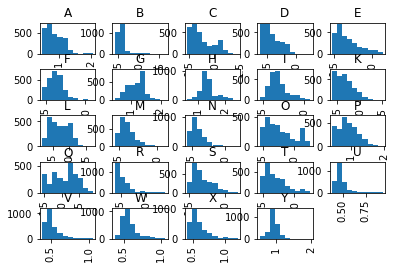

In [15]:
# Get the handshape from file name (convert number to letter)
img_df['handshape'] = img_df.apply(lambda row: chr(int(row.filename[:2])+65), axis=1)
# Plot the histograms by handshape
img_df['aspect'].hist(by=img_df['handshape'])

Now that it has been determined that rescaling is the best strategy, it now needs to be determined how large the rescaled images will be for the CNN architecture. It has already been said that a square image is preferred. More than $75\%$ of the images have aspect ratios less than $1.0$ so most images can be simply rescaled to a square by changing the width. 

Restricting the width to $125$ pixels would keep information preserved for about $75\%$ of the images. This seems to be a reasonable for width but height has to be considered as well. Restricting the image to $125$ pixels for height would mean information would be preserved for less than $25\%$ of the images. This looks to be a poor tradeoff especially considering that most images are tall and therefore most pictures would lose information.

Focusing on height instead, a restriction of $160$ pixels would preserve all the height information for about $75\%$ of the images. Good so far observing how many images would preserve all its width image is over $75\%$. This is great since most images will retain most (if not all) of their information.
  
In conclusion, resizing the images to be $160$ pixels by $160$ pixels will preserve most of the images' information. This size is also ideal since each dimension is divisible by $2^5$ which gives us a decently sized power of $2$. The total number of pixels for each image will be $25600$ pixels which is on the higher end but allows for a large proportion of the images to not lose information during the resize. There is a tradeoff between size and computation time so if this appears to be an issue during training, the image can be reduced farther so each dimension will be $134$ pixels giving a total number of pixels of $17956$. This would still keep over $75\%$ of images to retain most of their information after resizing.  

## Resizing images for model

Now that it has been determined what and how the images should be resized, we perform it on the dataset

In [16]:
# Convert image to new size and save file
def img_resize(width, height, img_file, new_name=None):
    img_path = os.path.join(final_data_dir, img_file)
    img = Image.open(img_path)
    img = img.resize((width, height))
    #
    if new_name != None:
        img_path = os.path.join(final_data_dir, new_name)
    img.save(img_path)
    

# Resize height and width (pixels) (160,160) --> (224,224) for ResNet50
new_width, new_height  = 224, 224

# Keep track coverts
n = 1
file_list = [x for x in os.listdir(final_data_dir) if re.search('\w*png', x)]
n_imgs = len(file_list)
errors_resize = []
errors = 0

# Resize all images
for img_filename in file_list:
    # Keep track of files that were not successfully resized
    try:
        # Open up the image file and resize
        img_resize(new_width, new_height, img_filename)
    except:
        errors_resize.append((n,img_filename))
        errors += 1
    # Message out    
    print('\r#{} of {}: Resizing image `{}` w/ {} errors'.format(n,n_imgs,img_filename,errors), end='')   
    n += 1
    sys.stdout.flush()

#65774 of 65774: Resizing image `07_2_0407.png` w/ 0 errors

In [17]:
data_dir = "data"



def move_data_by_category(container_dir, regex_file_format='.*png'):
    '''Move data into a directory based on category'''
    # Still check if files are images
    file_list = [x for x in os.listdir(container_dir) if re.search(regex_file_format, x)]
    # Get numerical string (note that 1 digits are represented w/ 2 digits) 
    letters = {x.split('_')[0] for x in file_list}
    
    for letter in letters:
        # Only images that match letter
        images_with_letter = [filename for filename in file_list if filename.split('_')[0] == letter]
        # Add images to sub directory
        new_categ_path = os.path.join(container_dir, letter)
        if not os.path.exists(new_categ_path):
            os.makedirs(new_categ_path)
#         print('Created {new_categ_path} dir with {len(images_with_letter)} items')
        for img_filename in images_with_letter:
            path = os.path.join(container_dir, img_filename)
            new_path = os.path.join(new_categ_path, img_filename)            
            os.rename(path, new_path)
    # TODO: Check if any files were skipped (improperly named?)
        

def get_testing_data(data_dir, subject_num='4'):
    '''Get all data/images pertaining to one subject'''
    # Only search in directory for images with that subject
    file_list = [x for x in os.listdir(data_dir) if re.search('\d+_{}_\d*\.png'.format(subject_num), x)]
    
    # Make a new testing data directory if doesn't exist
    testing_dir = os.path.join(data_dir, 'test')
    if not os.path.exists(testing_dir):
        os.makedirs(testing_dir)
        
    # Move images of particular subject into testing directory
    for image_filename in file_list:
        # file is **_n_****.png where n is an integer representing a subject
        _, subject, _ = image_filename.split('_')
        # Move file into testing directory
        path = os.path.join(data_dir, image_filename)
        new_path = os.path.join(testing_dir, image_filename)
        os.rename(path, new_path)
        
    # Move each image file's numerical str representing letters found in testing into own category directory
    move_data_by_category(testing_dir)


def get_training_validation_data(data_dir, ratio=0.8):
    '''Randomly split data into training and validation sets'''
    # Only search in directory for images
    file_list = [x for x in os.listdir(data_dir) if re.search('.*png', x)]
    
    # Make a new training & validation data directory if doesn't exist
    train_dir = os.path.join(data_dir, 'train')
    valid_dir = os.path.join(data_dir, 'valid')
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(valid_dir):
        os.makedirs(valid_dir)
        
    # Randomly split file list into training and vaidation sets
    np.random.shuffle(file_list)
    split_int = int(ratio * len(file_list))
    train_list = file_list[:split_int]
    valid_list = file_list[split_int:]
    
    # Move images of particular subject into testing directory
    for filenames, new_dir in [(train_list, train_dir), (valid_list, valid_dir)]:
        for image_filename in filenames:
            # Move file into testing directory
            path = os.path.join(data_dir, image_filename)
            new_path = os.path.join(new_dir, image_filename)
            os.rename(path, new_path)

        # Move each image file's numerical str representing letters found in testing into own category directory
        move_data_by_category(new_dir)

In [18]:
get_testing_data(data_dir)
get_training_validation_data(data_dir)